# Laboratorio 5. Redes Neuronales Recurrentes (RNN) para Series de Tiempo

- Diego Duarte 
- Paula Barillas

## Aplicación de Redes Neuronales Recurrentes (RNN, específicamente LSTM) para la predicción de series temporales reales

**Datos:** Producción industrial de helados y postres congelados en EE.UU. (FRED, Reserva Federal de St. Louis)

### Objetivos de aprendizaje
1. Comprender y aplicar los conceptos básicos del preprocesamiento de series de tiempo para modelado predictivo.
2. Implementar un generador de secuencias temporales para entrenamiento de redes.
3. Diseñar, entrenar y evaluar un modelo de tipo LSTM para predicción de series temporales.
4. Analizar y comparar el desempeño del modelo mediante métricas y visualizaciones.
5. Documentar adecuadamente el proceso seguido, justificando decisiones de diseño y parámetros.

---

## 1. Carga y exploración de datos
En esta sección se importan las librerías necesarias y se descarga la serie temporal de producción industrial de helados y postres congelados en EE.UU. desde FRED.

,IPN31152N
DATE,
2020-10-01,106.2640
2020-11-01,99.5616
2020-12-01,90.4432
2021-01-01,106.0187
2021-02-01,119.2644


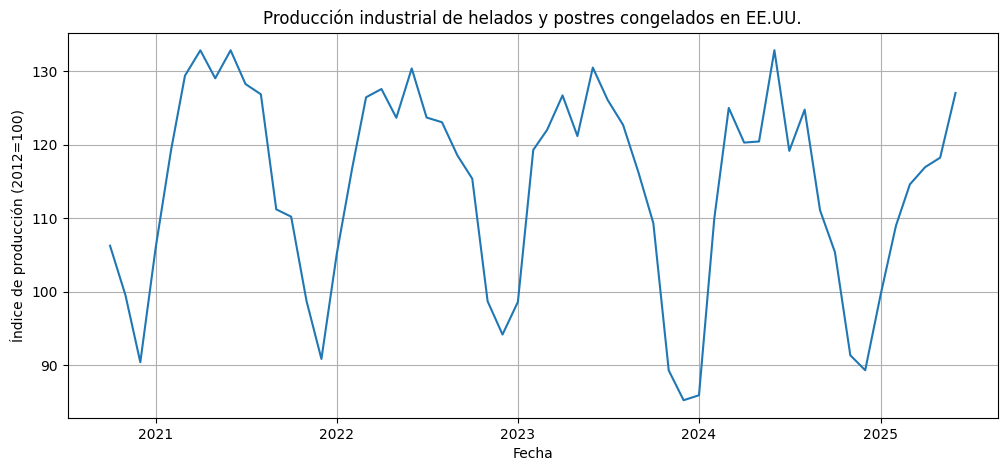

In [3]:
# !pip install pandas_datareader matplotlib --quiet
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

# datos de FRED
serie = pdr.DataReader('IPN31152N', 'fred')
serie = serie.dropna()  # Eliminar valores nulos si existen

# Visualizar las primeras filas
display(serie.head())

# Graficar la serie temporal
plt.figure(figsize=(12,5))
plt.plot(serie.index, serie['IPN31152N'])
plt.title('Producción industrial de helados y postres congelados en EE.UU.')
plt.xlabel('Fecha')
plt.ylabel('Índice de producción (2012=100)')
plt.grid(True)
plt.show()

## 2. División de conjuntos de entrenamiento y prueba
Se dividió la serie temporal en dos conjuntos:
- **Entrenamiento:** Todos los datos excepto los últimos 24 meses.
- **Prueba:** Los últimos 24 meses para evaluar la capacidad predictiva del modelo.

In [4]:
# División de los datos
n_test = 24  # Últimos 24 meses para prueba
train = serie.iloc[:-n_test]
test = serie.iloc[-n_test:]

print(f'Tamaño entrenamiento: {len(train)}')
print(f'Tamaño prueba: {len(test)}')
print('Rango entrenamiento:', train.index.min().date(), 'a', train.index.max().date())
print('Rango prueba:', test.index.min().date(), 'a', test.index.max().date())

Tamaño entrenamiento: 33
Tamaño prueba: 24
Rango entrenamiento: 2020-10-01 a 2023-06-01
Rango prueba: 2023-07-01 a 2025-06-01


## 3. Normalización y preparación de datos
Para mejorar el desempeño del modelo LSTM, se normalizaron los datos usando MinMaxScaler y se preparo las secuencias con TimeSeriesGenerator de Keras.

In [ ]:
# !pip install scikit-learn tensorflow --quiet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# normalización de los datos
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# pparámetros para el generador
n_input = 12  # meses de entrada para predecir el siguiente
batch_size = 1

# secuencias para entrenamiento
generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=batch_size)

print(f'Número de secuencias de entrenamiento: {len(generator)}')